# Spectral Proper Orthogonal Decomposition (SPOD)

#### This notebook calculates dominant time scales and associated spatial features in a dynamical process. 
#### The dynamical process is represented by a number of spatial snapshots captured from experiments or numerical simulations at regular time intervals which may include noise. 
#### The analysis assumes that: 
1. the captured dynamical process is statistically stationary,
2. the snapshots are captured at regular time interval ($\Delta t$),
3. the snapshots are captured as multiple realizations of the same experiment. Having multiple realizations help remove noise from the actual useful data. However, if the data is captured from a noise free experiment or numerical simulation, one could consider only one realization for the calculations and this method reduces to computing just a spatially averaged power spectral density of the data.

#### References:
1. https://doi.org/10.1017/jfm.2018.283 

#### Import libraries

In [1]:
import numpy as np 
import pandas as pd 
from scipy.fft import fftfreq, fft
from scipy import signal
import torch, torchvision
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [2]:
def POD(X):
    C = torch.mm(torch.flatten(X,1),torch.t(torch.flatten(X,1)))
    return torch.linalg.eigh(C)

In [3]:
if (torch.cuda.is_available()):
    torch.set_default_device('cuda')

In [4]:
N = 1000 # Total number of snapshots
dt = 1e-5  # Time interval between two consecutive snapshots
nx = 704//4 # Image resolution in vertical direction. //4 means we'll coarse-grain the inmage resolution by a factor of 4.
ny = 1392//4 # Image resolution in horizontal direction. //4 means we'll coarse-grain the inmage resolution by a factor of 4.

# Empty array to store snapshot data
data = torch.empty((N,nx,ny),dtype=torch.double)

# Read all snapshots
for i in tqdm(range(N)):
    
    # Reading images in grayscale.
	image = read_image('./results/post/schlieren/10/image.{:0=8}.png'.format(50080+80*i),mode = ImageReadMode.GRAY)
    
	# Image crop box: 184,174 --> 1284,774
	# image = T.functional.crop(image,174,184,600,1500)
    
	image = T.Resize([nx,],antialias=True)(image) # Resizing image
    
	image = T.functional.convert_image_dtype(image, dtype=torch.double) # convert image data type to double for further computation
    
	data[i] = image    # Store processed images in the data array.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.80it/s]


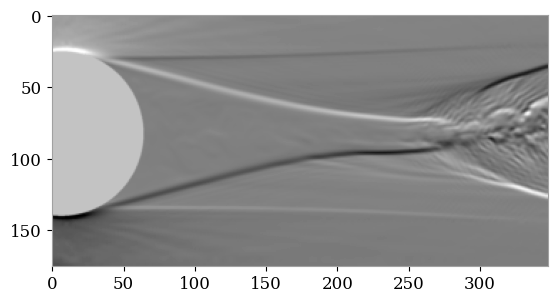

In [15]:
# Plotting sample image file
plt.imshow(data[0,].cpu(),cmap='gray')

#### If the dataset contains multiple realizations, every realization should contain same number of snapshots at same time interval dt
#### No. of realization in the dataset = Nbk.
#### No. of snapshots in one realization = M

In [5]:
Nblk = 1
M = N
shift = (N-M)//Nblk

frequency = torch.fft.fftfreq(M,dt)[:M//2] # Store frequency array
PSD = torch.empty((Nblk,M//2,nx,ny),dtype=torch.double) # Storage array for Power Spectral Density (PSD) of the snapshots in Fourier space.

# Compute and store PSD for each block at each spatial location i,j
for blk in range(Nblk):
    start=blk*shift
    end = start+M
    for i in tqdm(range(nx)):
    	for j in range(ny):
    		PSD[blk,:,i,j] = (abs(torch.fft.fft(data[start:end,i,j]))[:M//2])/(M**2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:01<00:00, 89.46it/s]


In [6]:
EigenValues = torch.empty((M//2,Nblk),dtype=torch.double) # Store Eigen-values
EigenVectors = torch.empty((M//2,M//2,Nblk),dtype=torch.double) # Store Eigen-vectors
for f in tqdm(range(M//2)):
    EigenValues[f,:],EigenVectors[f,:,:] = POD(PSD[:,f,:,:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 662.06it/s]


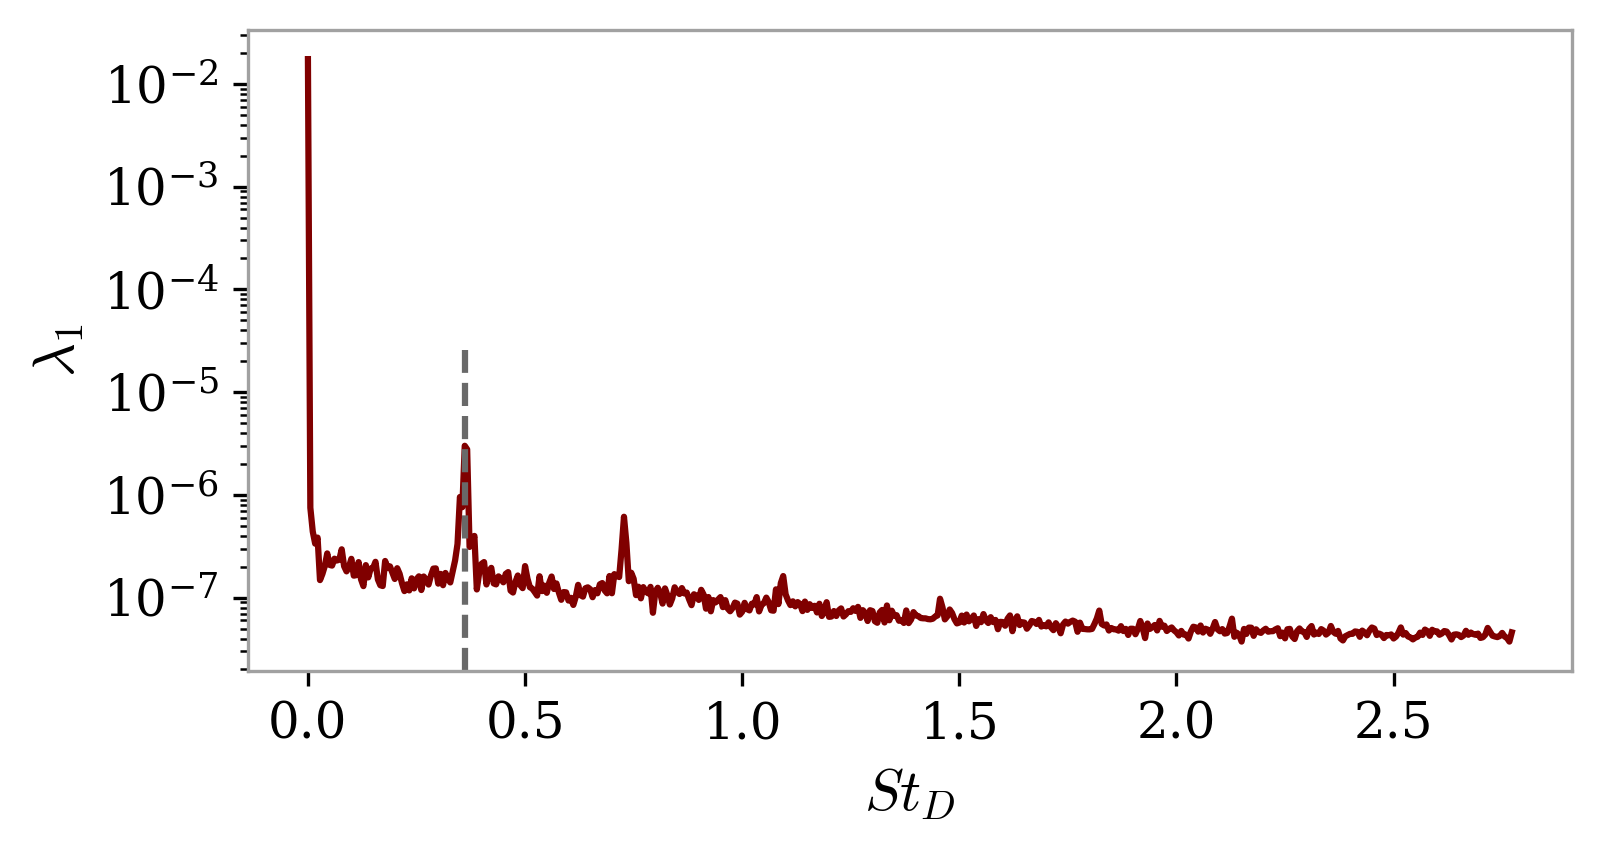

In [7]:
# Plot spectra for first dominant mode = 0
mode = 0
COLOR='#a1a1a1'
fig = plt.figure(figsize=(5.5,3),dpi=300)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.edgecolor'] = COLOR
plt.plot(frequency.cpu()*(0.05/900), EigenValues[:,mode].cpu(),color='maroon')
plt.axvline(x=0.362,ymax=0.5,color='dimgrey',linestyle='dashed')
plt.yscale('log')
# plt.ylim(1e-7,1e-5)
# plt.xlim(0,0.6)
plt.xlabel(r'$St_D$', fontsize=14)
plt.ylabel(r'$\lambda_1$', fontsize=14)
plt.tight_layout()
# plt.savefig('./spectra_4.png')

## Spatial dominant features could also be extracted from projection of EigenVectors to physical space.

This section will be updated soon...